# Chapter 4.6

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

## Self-created functions

In [3]:
def node_pruning(model, tester_model, x, y, layer_sizes, tol):

    loss, acc = model.evaluate(x, y, verbose=0, batch_size=256)
    original = model.get_weights()
    weight_len = len(original) - 3
    bas = [acc]
    bls = [loss]
    best_weights = model.get_weights()
    best_acc = 0
    best_loss = 1e20
    ol = loss
    oa = acc
    amounts = []
    places = []

    for layer, size in enumerate(layer_sizes):
        end_not_reached = True
        current_pos = 0
        num_removed = 0
        best_pos = -1
        best_change = tol
        nodes_removed = []
        improved = False
        while end_not_reached or improved:
            if not(end_not_reached):
                end_not_reached = True
                improved = False
                current_pos = 0
                size -= 1
                nodes_removed += [best_pos]
                best_weights[weight_len - (2*layer+1)][...,best_pos] = 0
                best_weights[weight_len - 2*layer][best_pos] = 0
                best_pos = -1
                ol = best_loss
                oa = best_acc
                bas += [best_acc]
                bls += [best_loss]
                best_change = tol
                num_removed += 1
            if current_pos in nodes_removed:
                current_pos += 1
                if current_pos - num_removed >= size:
                    end_not_reached = False
                continue
            w = copy.deepcopy(best_weights)
            w[weight_len - (2*layer+1)][...,current_pos] = 0
            w[weight_len - 2*layer][current_pos] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            if ol - nl >= best_change:
                best_change = ol - nl
                best_pos = current_pos
                improved = True
                best_acc = na
                best_loss = nl
            current_pos += 1
            if current_pos - num_removed >= size:
                end_not_reached = False
        amounts.append(num_removed)
        places.append(nodes_removed)

    return best_weights, bas, bls, amounts, places

## Single-layer ANN

### MNIST

#### Set seed

In [4]:
np.random.seed(2020)

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [6]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
trials = 20
tol = -1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += tmp_a
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:32:42<00:00, 278.13s/it]


In [8]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_exh_pru_mnist.csv')
NR.describe()

count    20.000000
mean      6.650000
std       1.954078
min       4.000000
25%       5.000000
50%       6.500000
75%       7.250000
max      11.000000
dtype: float64

In [9]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_exh_pru_mnist.csv')
A.describe()

count    20.000000
mean      0.001525
std       0.001055
min      -0.000200
25%       0.000725
50%       0.001450
75%       0.001975
max       0.003500
dtype: float64

In [10]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_exh_pru_mnist.csv')
L.describe()

count    20.000000
mean     -0.005032
std       0.003399
min      -0.011152
25%      -0.008121
50%      -0.004268
75%      -0.002103
max      -0.000876
dtype: float64

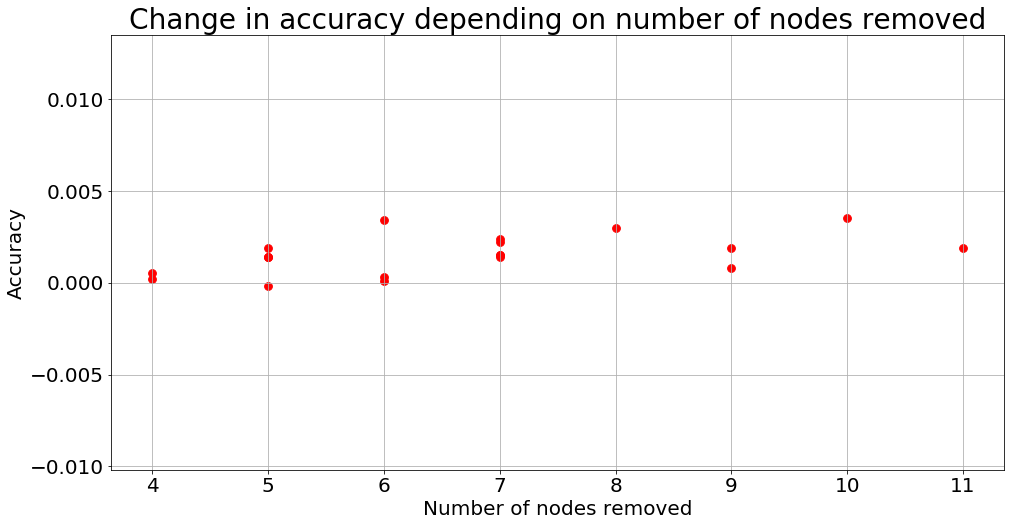

In [11]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_exh_pru_mnist.png")

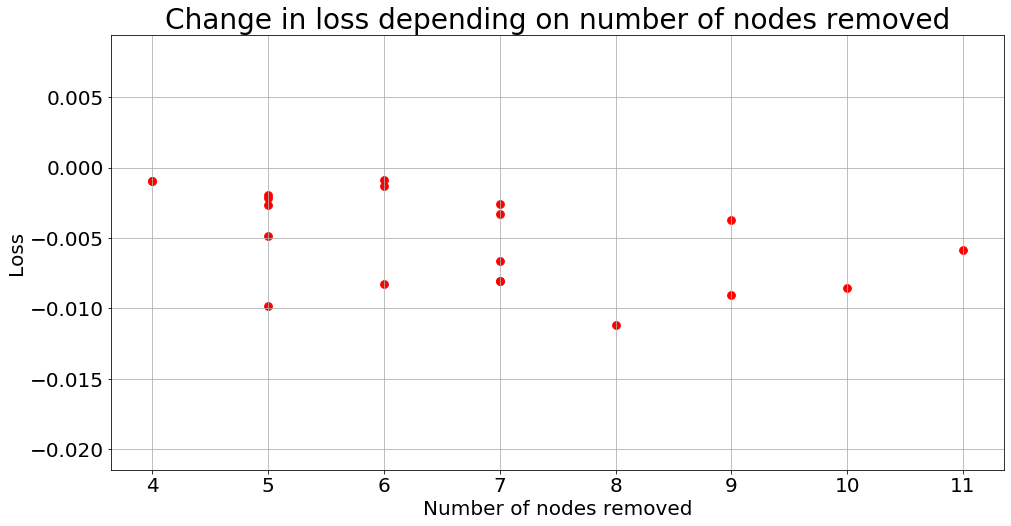

In [12]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_exh_pru_mnist.png")

In [13]:
tol = -1e-5
layer_sizes = [128]
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [14]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.06950690597295761, New loss: 0.06689056754112244
Original accuracy: 0.9782999753952026, New accuracy: 0.9797000288963318
Number of nodes removed: [2]


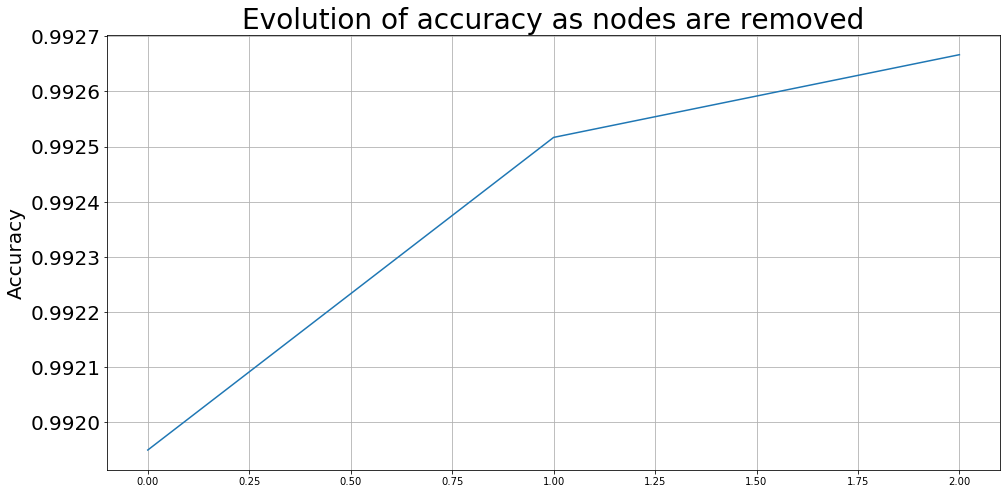

In [15]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_acc_ANN_exh_pru_mnist.png")

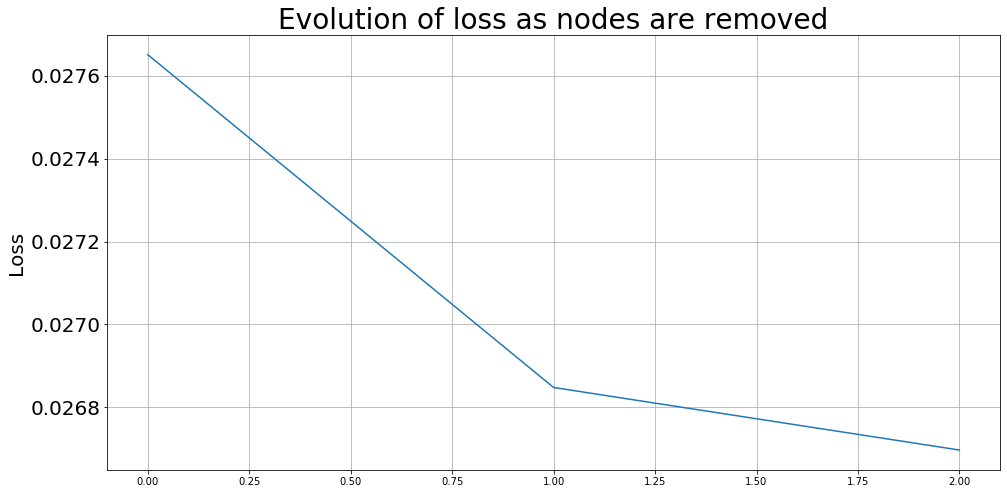

In [16]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_loss_ANN_exh_pru_mnist.png")

### Validation removal

In [17]:
np.random.seed(2020)

In [18]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [19]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [21]:
trials = 20
tol = -1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += tmp_a
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [39:00<00:00, 117.03s/it]


In [22]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_exh_pru_val_mnist.csv')
NR.describe()

count    20.000000
mean     12.700000
std       2.921787
min       8.000000
25%      11.500000
50%      14.000000
75%      15.000000
max      17.000000
dtype: float64

In [23]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_exh_pru_val_mnist.csv')
A.describe()

count    20.000000
mean      0.001310
std       0.001603
min      -0.001300
25%      -0.000100
50%       0.001400
75%       0.002375
max       0.004000
dtype: float64

In [24]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_exh_pru_val_mnist.csv')
L.describe()

count    20.000000
mean     -0.005130
std       0.004028
min      -0.011916
25%      -0.007692
50%      -0.005956
75%      -0.001706
max       0.002919
dtype: float64

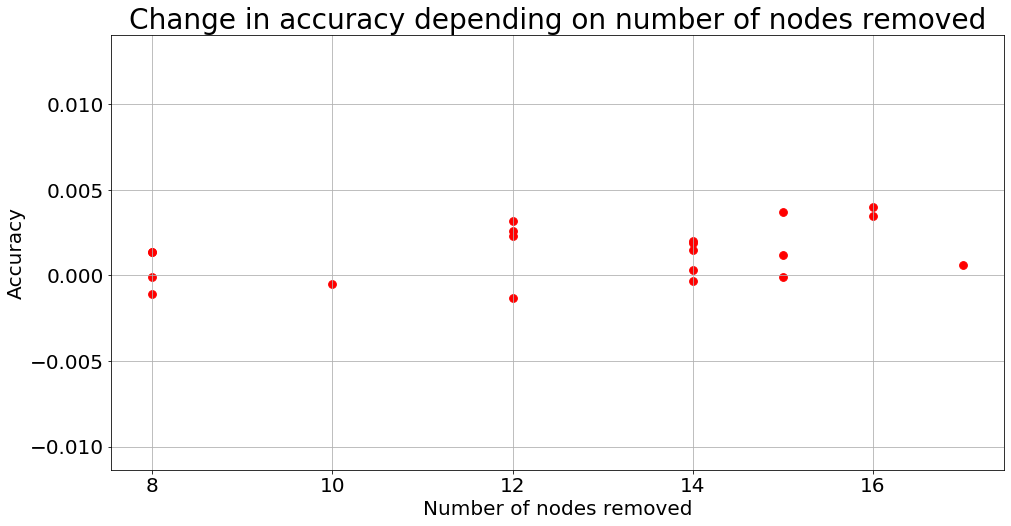

In [25]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_exh_pru_val_mnist.png")

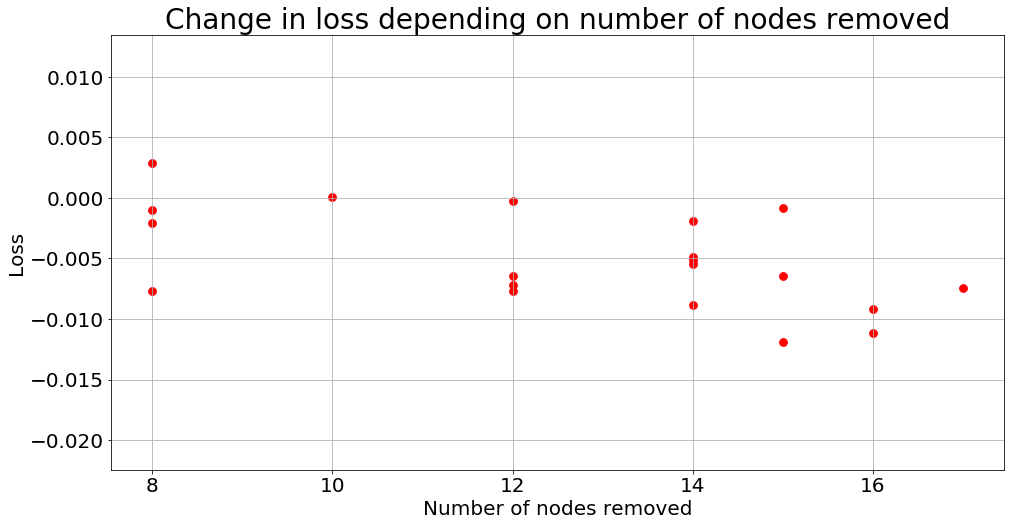

In [26]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_exh_pru_val_mnist.png")

In [27]:
tol = -1e-5
layer_sizes = [128]
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_val, y_val), epochs=5)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [28]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.08331171423196793, New loss: 0.07726792246103287
Original accuracy: 0.9758999943733215, New accuracy: 0.9768000245094299
Number of nodes removed: [15]


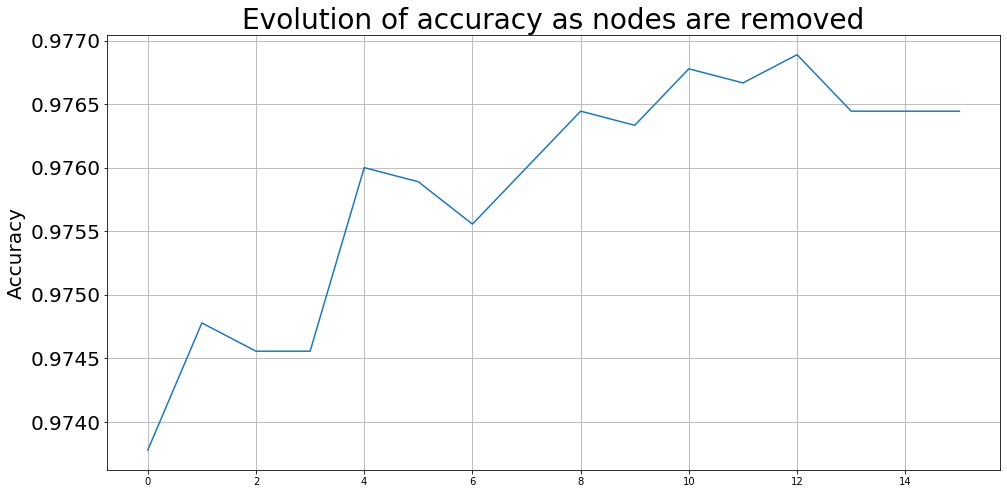

In [29]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_acc_ANN_exh_pru_val_mnist.png")

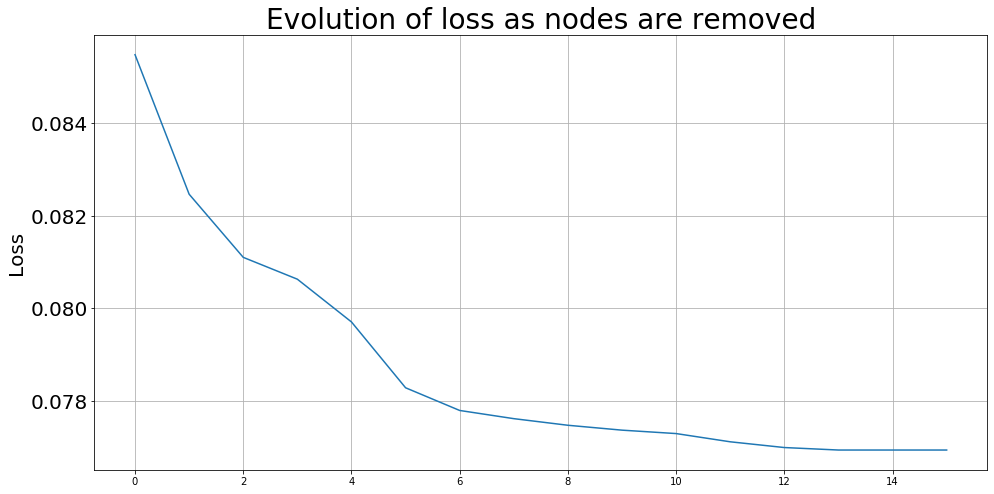

In [30]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_loss_ANN_exh_pru_val_mnist.png")

### Fashion MNIST

#### Set seed

In [31]:
np.random.seed(2020)

In [32]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [33]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
trials = 20
tol = -1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += tmp_a
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [3:57:46<00:00, 713.32s/it]


In [35]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_exh_pru_fmnist.csv')
NR.describe()

count    20.000000
mean     20.050000
std       2.837252
min      14.000000
25%      19.000000
50%      20.000000
75%      22.000000
max      26.000000
dtype: float64

In [36]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_exh_pru_fmnist.csv')
A.describe()

count    20.000000
mean      0.004990
std       0.004251
min      -0.000300
25%       0.001500
50%       0.004000
75%       0.008350
max       0.012300
dtype: float64

In [37]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_exh_pru_fmnist.csv')
L.describe()

count    20.000000
mean     -0.014887
std       0.009549
min      -0.033680
25%      -0.022352
50%      -0.012940
75%      -0.008256
max      -0.002196
dtype: float64

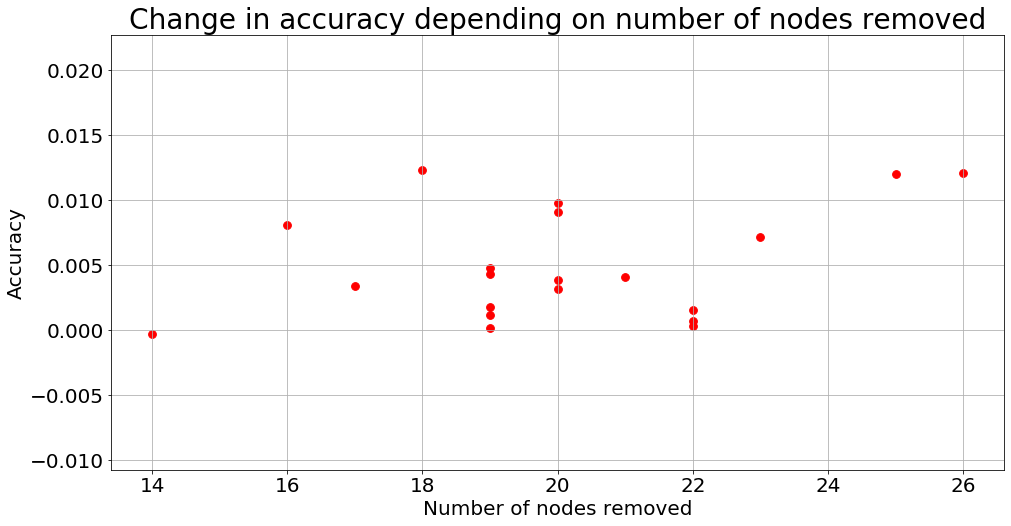

In [38]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_exh_pru_fmnist.png")

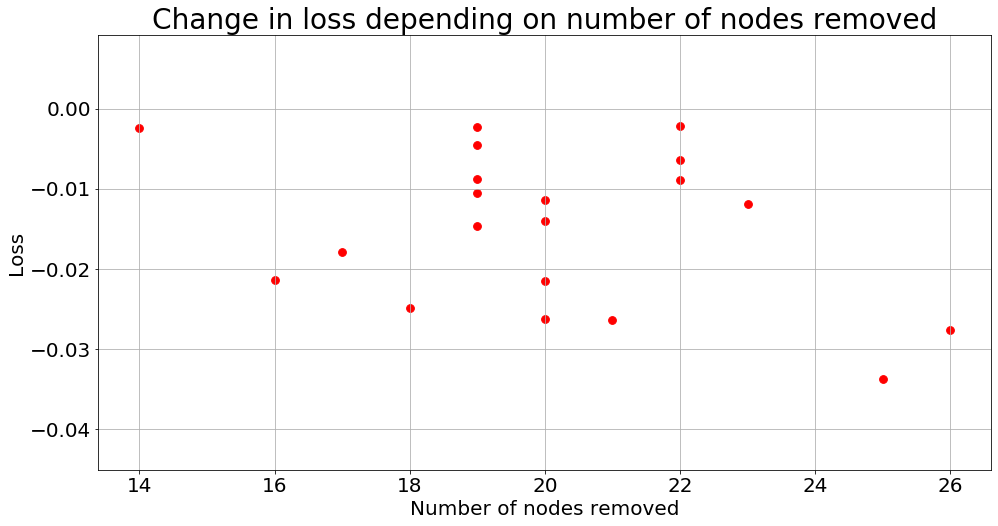

In [39]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_exh_pru_fmnist.png")

In [40]:
tol = -1e-5
layer_sizes = [128]
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [41]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.37115487456321716, New loss: 0.34189990162849426
Original accuracy: 0.8651999831199646, New accuracy: 0.8761000037193298
Number of nodes removed: [14]


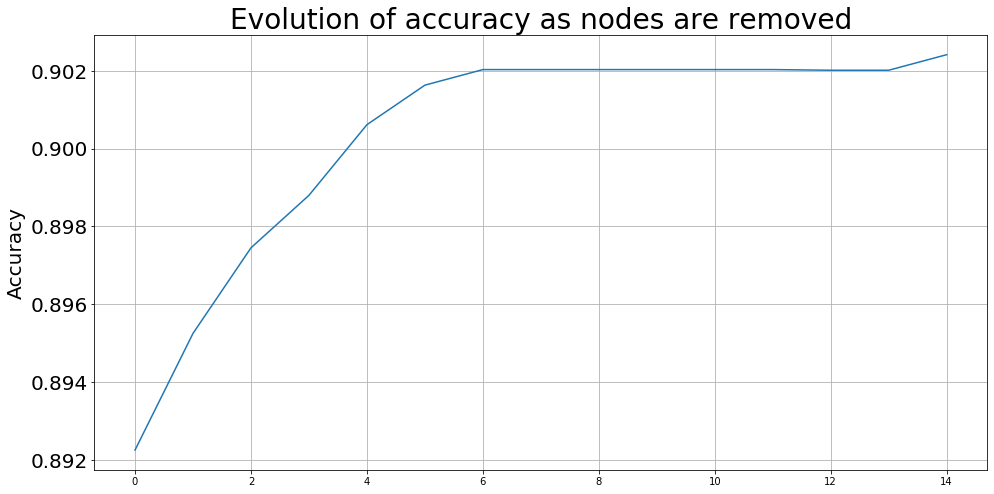

In [42]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_acc_ANN_exh_pru_fmnist.png")

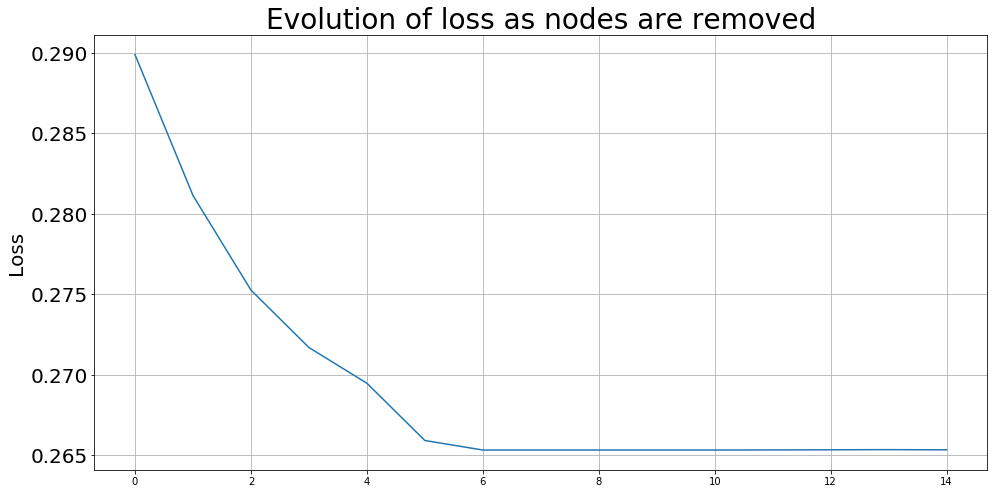

In [43]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_loss_ANN_exh_pru_fmnist.png")

### Validation removal

In [44]:
np.random.seed(2020)

In [45]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [46]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [48]:
trials = 20
tol = -1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += tmp_a
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:12:28<00:00, 217.42s/it]


In [49]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_exh_pru_val_fmnist.csv')
NR.describe()

count    20.000000
mean     27.000000
std       2.973568
min      23.000000
25%      24.000000
50%      26.500000
75%      29.000000
max      33.000000
dtype: float64

In [50]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_exh_pru_val_fmnist.csv')
A.describe()

count    20.000000
mean      0.007250
std       0.004097
min       0.001100
25%       0.004775
50%       0.005750
75%       0.009200
max       0.015100
dtype: float64

In [51]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_exh_pru_val_fmnist.csv')
L.describe()

count    20.000000
mean     -0.020823
std       0.011616
min      -0.044132
25%      -0.027541
50%      -0.016182
75%      -0.012015
max      -0.009732
dtype: float64

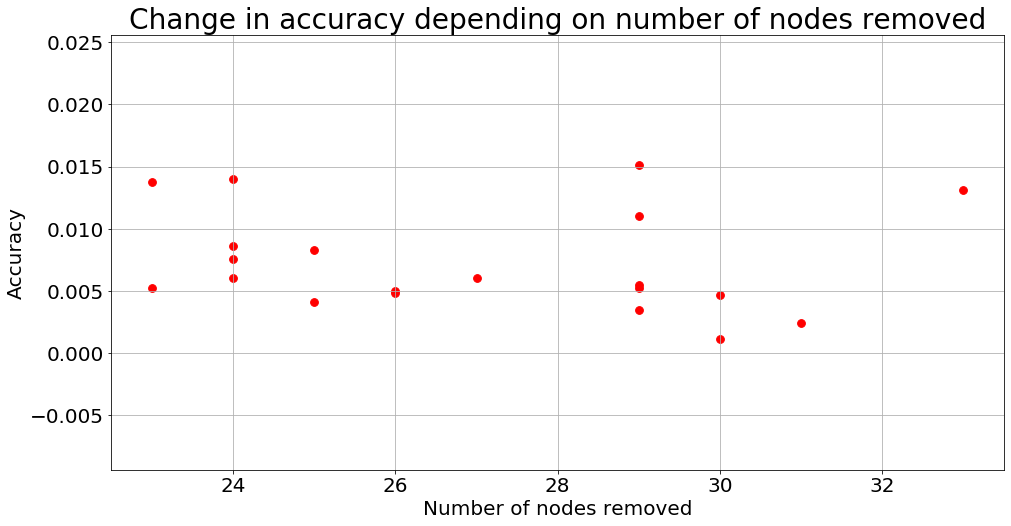

In [52]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_exh_pru_val_fmnist.png")

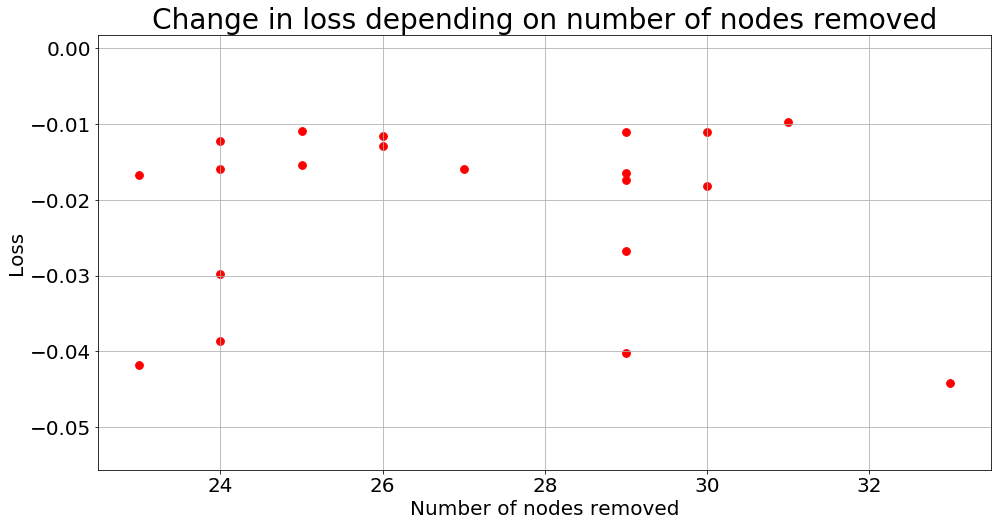

In [53]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_exh_pru_val_fmnist.png")

In [54]:
tol = -1e-5
layer_sizes = [128]
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [55]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.3497755527496338, New loss: 0.3396252691745758
Original accuracy: 0.8748000264167786, New accuracy: 0.8791999816894531
Number of nodes removed: [25]


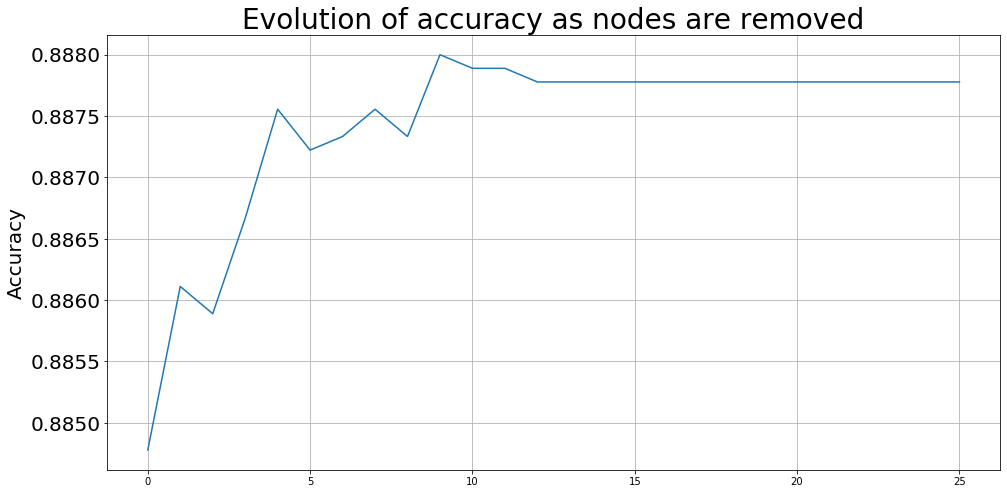

In [56]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_acc_ANN_exh_pru_val_fmnist.png")

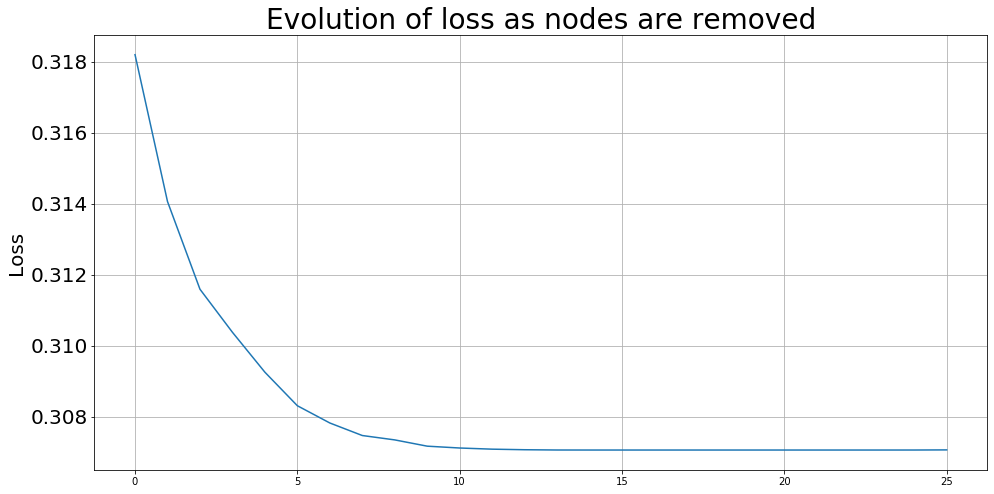

In [57]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/ev_loss_ANN_exh_pru_val_fmnist.png")

## Multi-layer Perceptron

### MNIST

#### Set seed

In [65]:
np.random.seed(2020)

In [66]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [67]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
trials = 10
tol = -1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:04:17<00:00, 385.75s/it]


In [69]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_exh_pru_mnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000
mean,3.400000,4.000000,5.800000
std,1.505545,1.763834,2.973961
min,1.000000,0.000000,2.000000
25%,2.000000,3.250000,3.250000
50%,4.000000,4.000000,5.500000
75%,4.750000,5.000000,8.250000
max,5.000000,6.000000,10.000000


In [70]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_exh_pru_mnist.csv')
A.describe()

count    10.000000
mean      0.002280
std       0.001887
min      -0.000100
25%       0.001000
50%       0.001950
75%       0.003500
max       0.005400
dtype: float64

In [71]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_exh_pru_mnist.csv')
L.describe()

count    10.000000
mean     -0.009070
std       0.007546
min      -0.025852
25%      -0.009948
50%      -0.007292
75%      -0.004567
max      -0.001725
dtype: float64

In [72]:
num_rem = [sum(rem) for rem in num_rem]

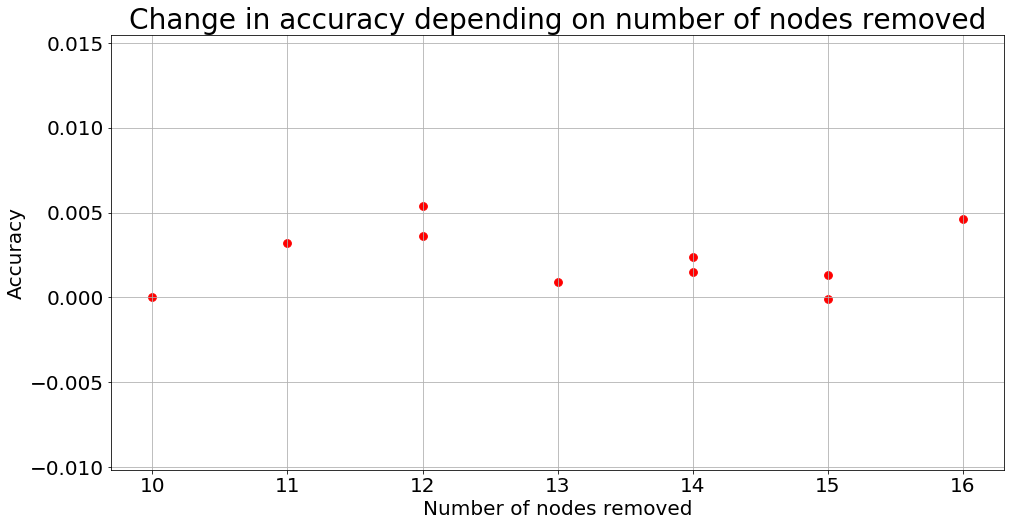

In [73]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_exh_pru_mnist.png")

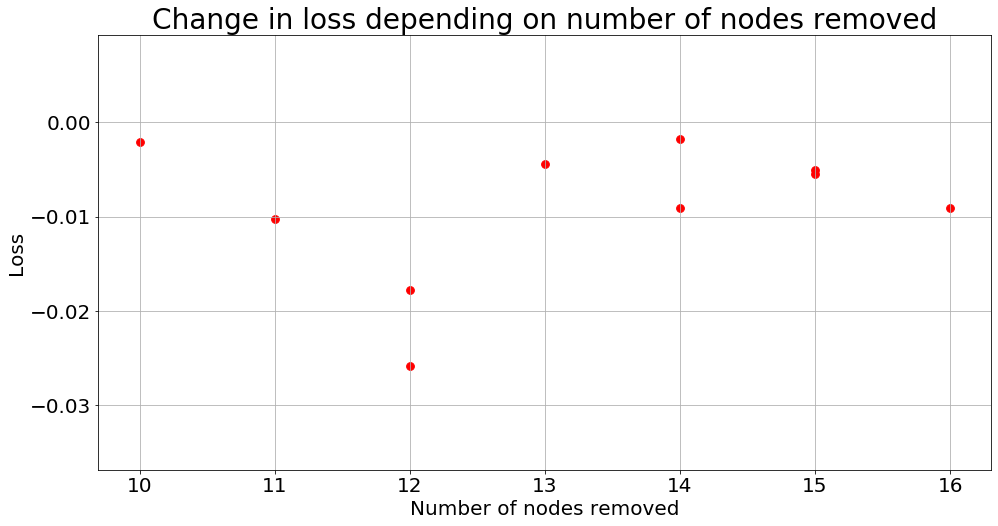

In [74]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_exh_pru_mnist.png")

In [75]:
tol = -1e-5
layer_sizes = [32, 64, 128]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [76]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.08167996257543564, New loss: 0.07723177224397659
Original accuracy: 0.9739999771118164, New accuracy: 0.9763000011444092
Number of nodes removed: [5, 2, 4]


In [77]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

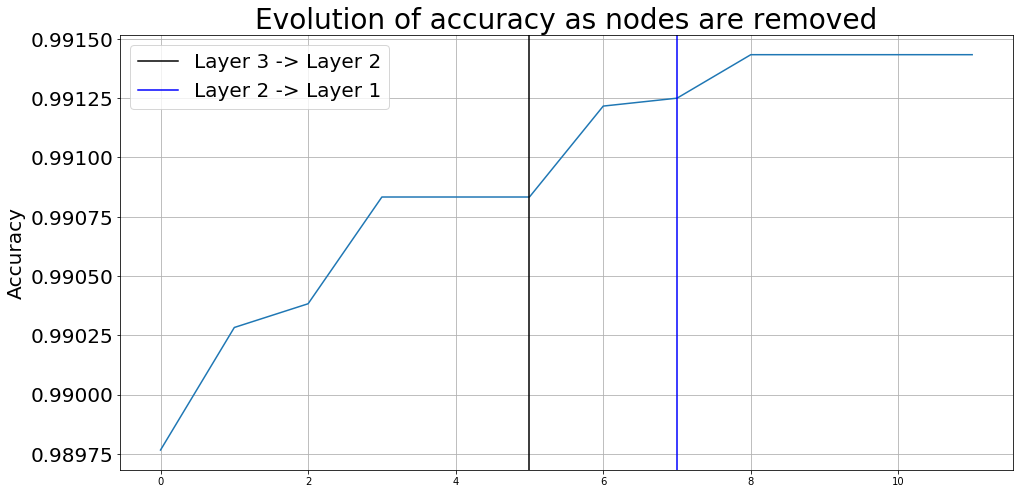

In [78]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_MLP_exh_pru_mnist.png")

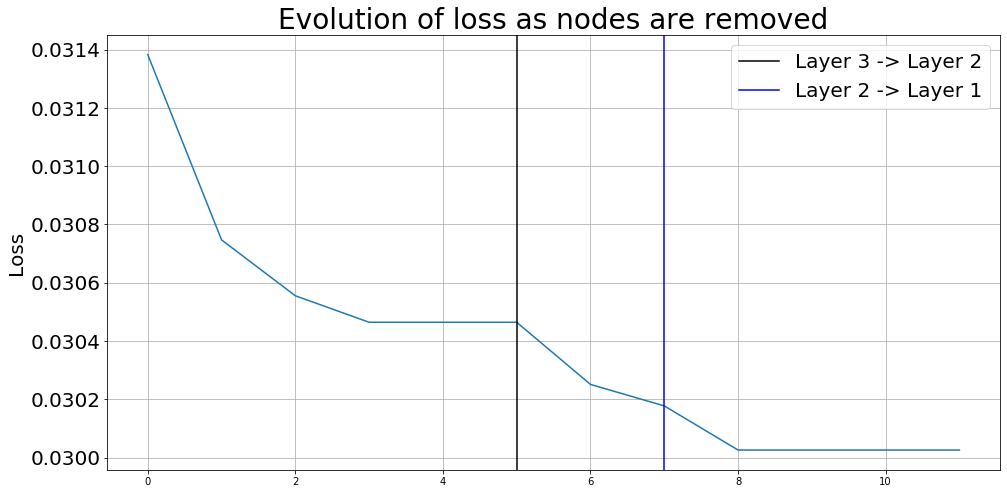

In [79]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_MLP_exh_pru_mnist.png")

### Validation removal

In [80]:
np.random.seed(2020)

In [81]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [82]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [83]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [84]:
trials = 10
tol = -1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [28:26<00:00, 170.68s/it]


In [85]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_exh_pru_val_mnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000
mean,5.500000,8.400000,12.100000
std,2.173067,2.065591,3.071373
min,3.000000,5.000000,9.000000
25%,3.500000,7.500000,10.000000
50%,5.000000,9.000000,10.500000
75%,7.000000,9.750000,14.750000
max,9.000000,11.000000,17.000000


In [86]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_exh_pru_val_mnist.csv')
A.describe()

count    10.000000
mean      0.002450
std       0.002309
min      -0.000300
25%       0.000950
50%       0.001850
75%       0.003975
max       0.005900
dtype: float64

In [87]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_exh_pru_val_mnist.csv')
L.describe()

count    10.000000
mean     -0.013572
std       0.007957
min      -0.028855
25%      -0.019253
50%      -0.011680
75%      -0.007864
max      -0.003645
dtype: float64

In [88]:
num_rem = [sum(rem) for rem in num_rem]

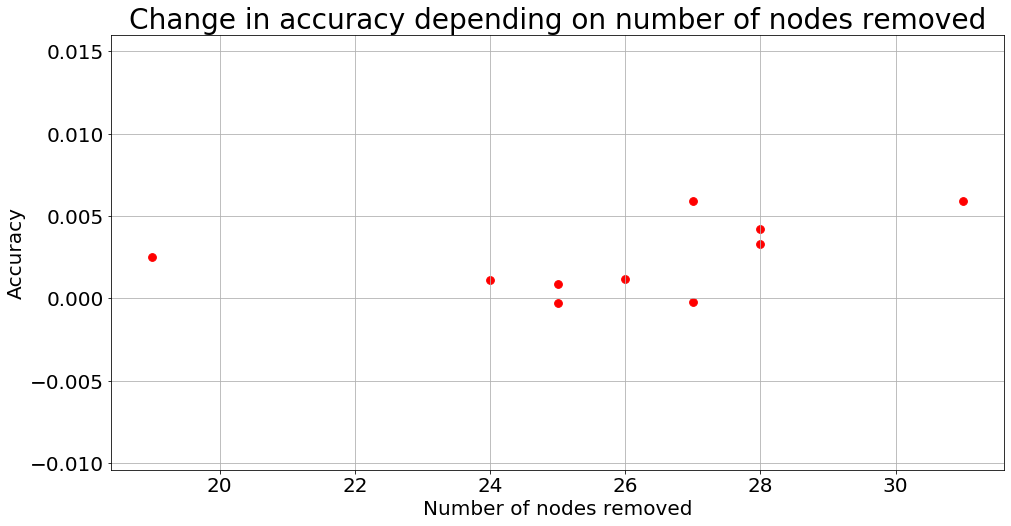

In [89]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_exh_pru_val_mnist.png")

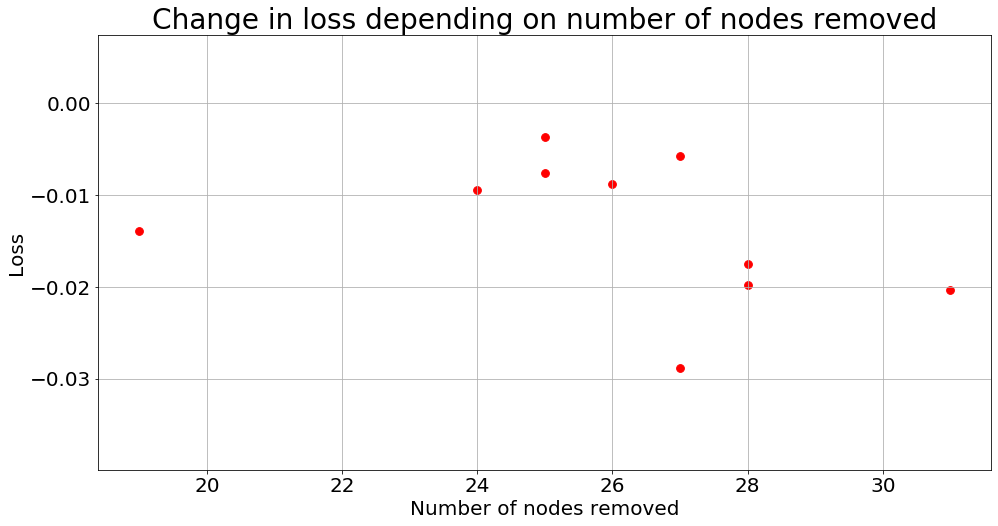

In [90]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_exh_pru_val_mnist.png")

In [91]:
tol = -1e-5
layer_sizes = [32, 64, 128]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [92]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.11419966071844101, New loss: 0.09285236895084381
Original accuracy: 0.9690999984741211, New accuracy: 0.974399983882904
Number of nodes removed: [3, 8, 14]


In [93]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

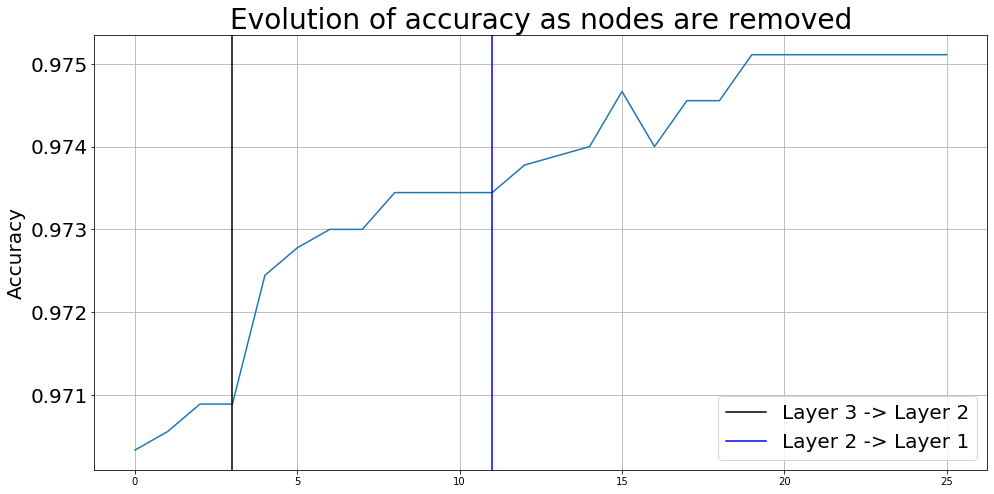

In [94]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_MLP_exh_pru_val_mnist.png")

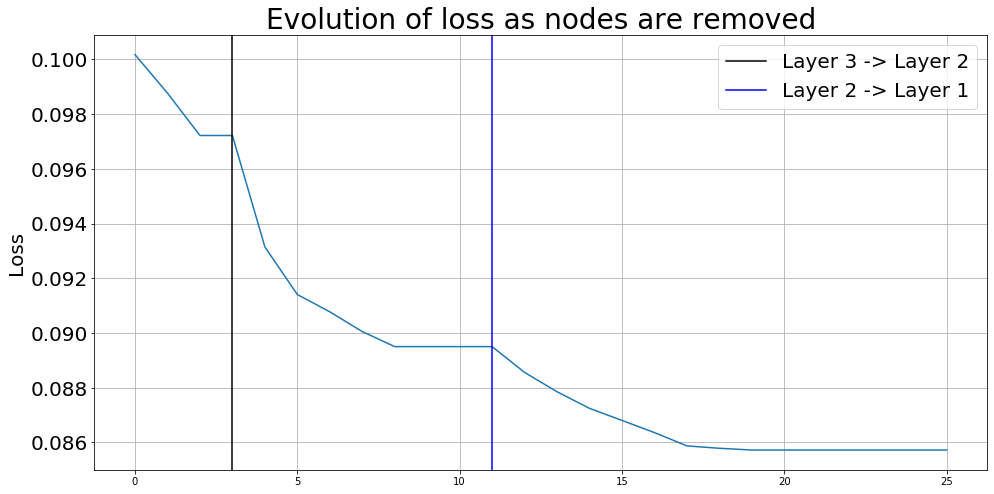

In [95]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_MLP_exh_pru_val_mnist.png")

### Fashion MNIST

#### Set seed

In [96]:
np.random.seed(2020)

In [97]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [98]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [99]:
trials = 10
tol = -1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [2:53:27<00:00, 1040.72s/it]


In [100]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_exh_pru_fmnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000
mean,4.600000,7.900000,23.000000
std,1.837873,2.282786,3.527668
min,2.000000,6.000000,19.000000
25%,3.250000,6.000000,20.000000
50%,4.500000,7.500000,22.500000
75%,5.000000,8.750000,25.500000
max,8.000000,13.000000,30.000000


In [101]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_exh_pru_fmnist.csv')
A.describe()

count    10.000000
mean      0.005930
std       0.002298
min       0.001700
25%       0.004875
50%       0.005500
75%       0.007075
max       0.009700
dtype: float64

In [102]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_exh_pru_fmnist.csv')
L.describe()

count    10.000000
mean     -0.018601
std       0.006778
min      -0.028139
25%      -0.024835
50%      -0.017074
75%      -0.014350
max      -0.007483
dtype: float64

In [103]:
num_rem = [sum(rem) for rem in num_rem]

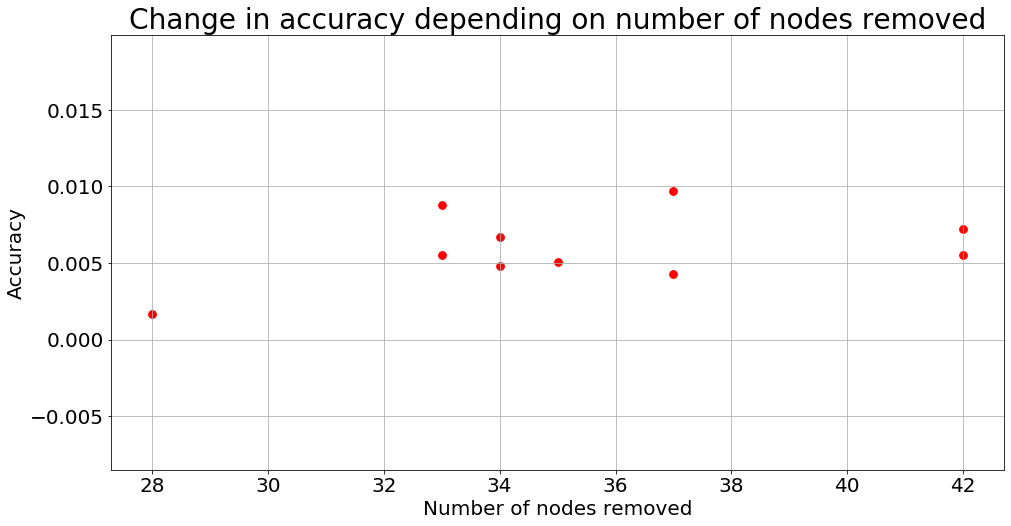

In [104]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_exh_pru_fmnist.png")

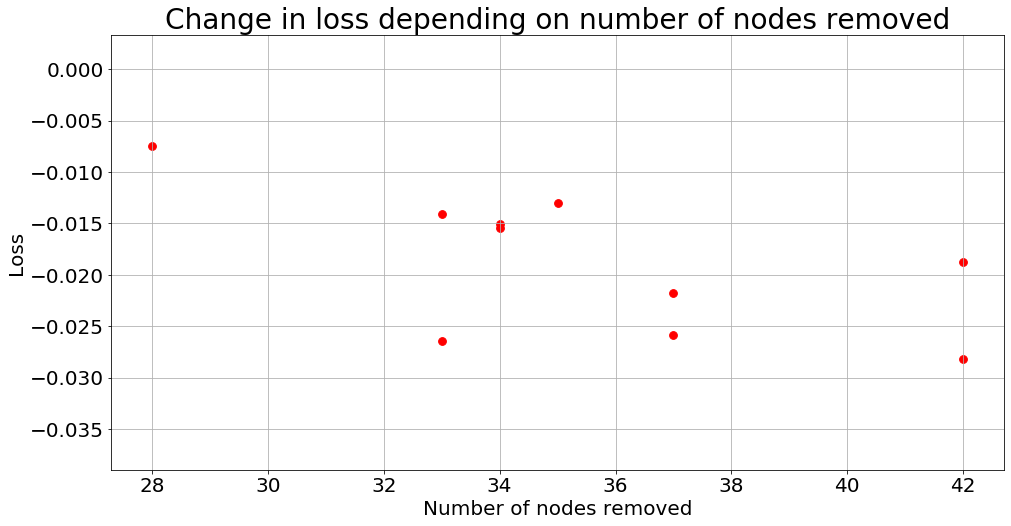

In [105]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_exh_pru_fmnist.png")

In [106]:
tol = -1e-5
layer_sizes = [32, 64, 128]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [107]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.34532806277275085, New loss: 0.3282015323638916
Original accuracy: 0.8784999847412109, New accuracy: 0.8830000162124634
Number of nodes removed: [3, 4, 19]


In [108]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

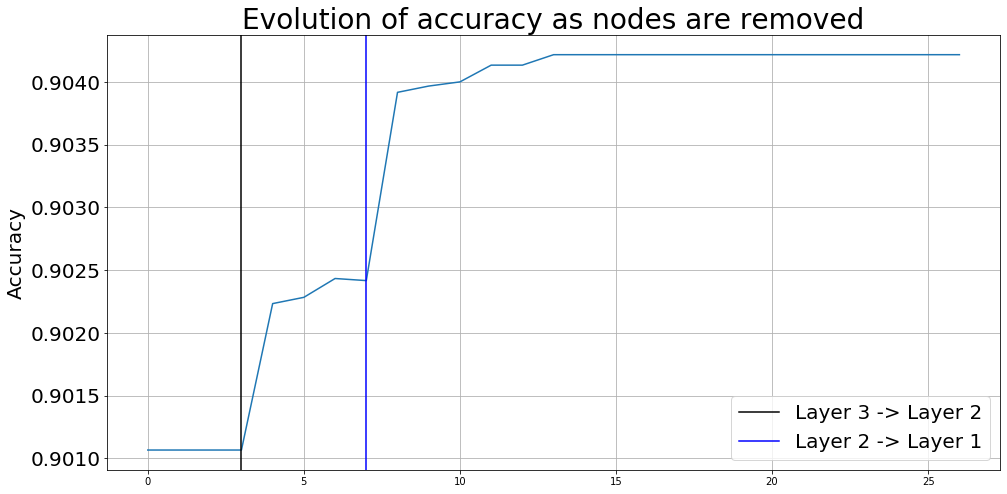

In [109]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_MLP_exh_pru_fmnist.png")

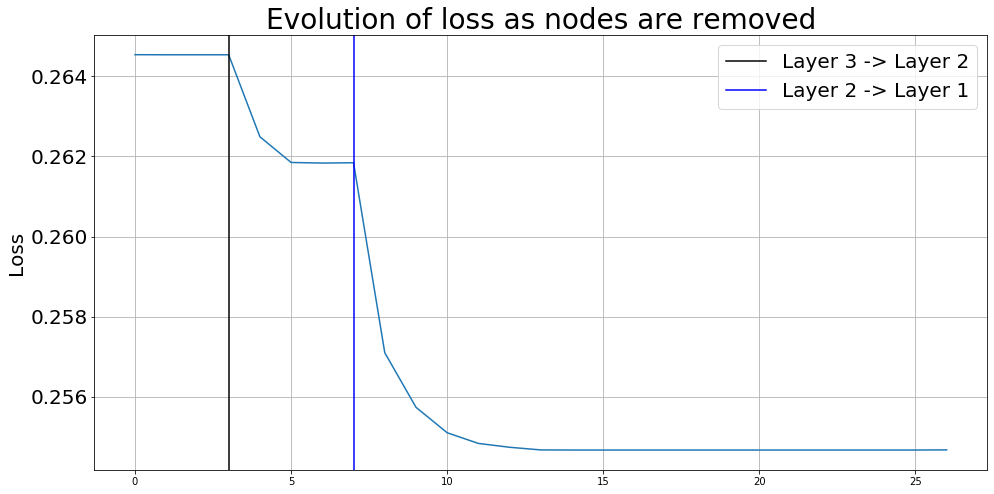

In [110]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_MLP_exh_pru_fmnist.png")

### Validation removal

In [111]:
np.random.seed(2020)

In [112]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [113]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [114]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [115]:
trials = 10
tol = -1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [45:15<00:00, 271.56s/it]


In [116]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_exh_pru_val_fmnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000
mean,6.400000,9.900000,25.900000
std,1.712698,3.446415,3.784471
min,3.000000,6.000000,20.000000
25%,6.000000,8.000000,22.750000
50%,6.000000,9.500000,26.000000
75%,7.750000,10.000000,28.000000
max,9.000000,18.000000,31.000000


In [117]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_exh_pru_val_fmnist.csv')
A.describe()

count    10.000000
mean      0.008490
std       0.003042
min       0.005700
25%       0.006300
50%       0.006700
75%       0.010150
max       0.014000
dtype: float64

In [118]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_exh_pru_val_fmnist.csv')
L.describe()

count    10.000000
mean     -0.018158
std       0.006855
min      -0.027120
25%      -0.024108
50%      -0.017580
75%      -0.014590
max      -0.007056
dtype: float64

In [119]:
num_rem = [sum(rem) for rem in num_rem]

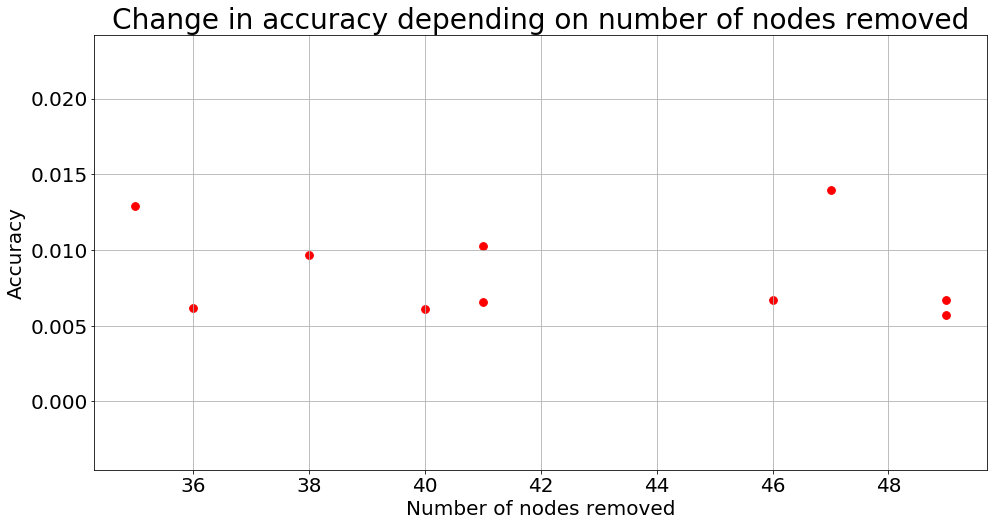

In [120]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_exh_pru_val_fmnist.png")

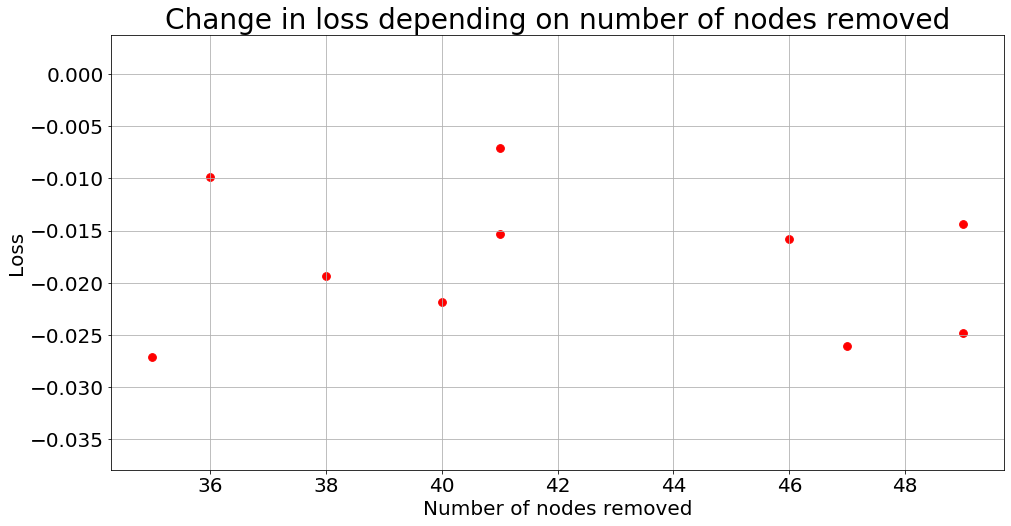

In [121]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_exh_pru_val_fmnist.png")

In [122]:
tol = -1e-5
layer_sizes = [32, 64, 128]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [123]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.3531306982040405, New loss: 0.3455771803855896
Original accuracy: 0.8707000017166138, New accuracy: 0.8744000196456909
Number of nodes removed: [4, 11, 23]


In [124]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

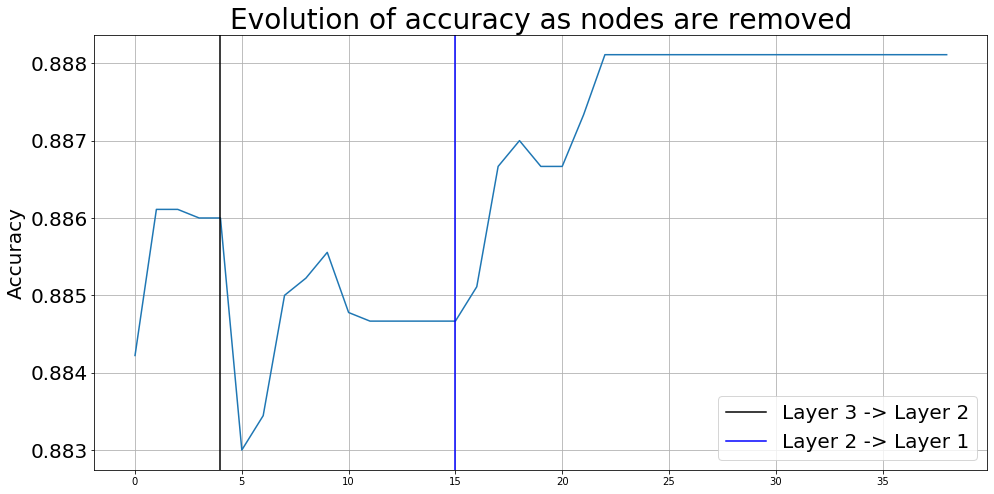

In [125]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_MLP_exh_pru_val_fmnist.png")

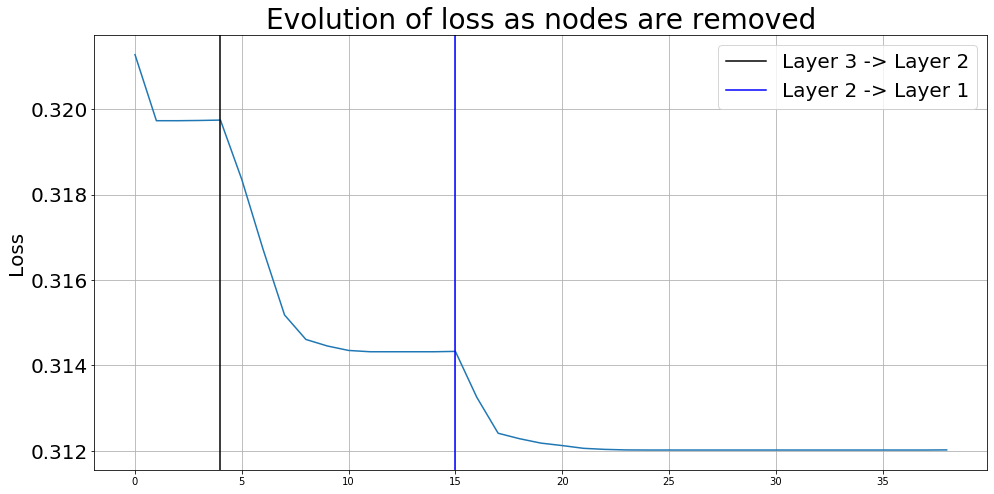

In [126]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_MLP_exh_pru_val_fmnist.png")

## Convolutional Neural Network

### MNIST

#### Set seed

In [127]:
np.random.seed(2020)

In [128]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [129]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [130]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

 40%|██████████████████████████████▍                                             | 2/5 [8:32:31<12:48:47, 15375.77s/it]


MemoryError: Unable to allocate 179. MiB for an array with shape (60000, 28, 28, 1) and data type float32

In [ ]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_exh_pru_mnist.csv')
NR.describe()

In [ ]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_exh_pru_mnist.csv')
A.describe()

In [ ]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_exh_pru_mnist.csv')
L.describe()

In [ ]:
num_rem = [sum(rem) for rem in num_rem]

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_exh_pru_mnist.png")

In [ ]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_exh_pru_mnist.png")

In [ ]:
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

In [ ]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

In [ ]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_exh_pru_mnist.png")

In [ ]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_exh_pru_mnist.png")

### Validation removal

In [131]:
np.random.seed(2020)

In [132]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [133]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [134]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [135]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:34:40<00:00, 2576.06s/it]


In [136]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_exh_pru_val_mnist.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.000000,5.000000,5.000000,5.00000,5.00000
mean,34.200000,79.600000,18.800000,2.80000,3.60000
std,4.438468,10.212737,2.280351,0.83666,2.19089
min,29.000000,68.000000,16.000000,2.00000,0.00000
25%,30.000000,70.000000,17.000000,2.00000,4.00000
50%,36.000000,82.000000,19.000000,3.00000,4.00000
75%,37.000000,87.000000,21.000000,3.00000,4.00000
max,39.000000,91.000000,21.000000,4.00000,6.00000


In [137]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_exh_pru_val_mnist.csv')
A.describe()

count    5.000000
mean     0.002360
std      0.001557
min      0.000200
25%      0.001200
50%      0.003400
75%      0.003500
max      0.003500
dtype: float64

In [138]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_exh_pru_val_mnist.csv')
L.describe()

count    5.000000
mean    -0.009234
std      0.005580
min     -0.013735
25%     -0.012908
50%     -0.012788
75%     -0.005537
max     -0.001203
dtype: float64

In [139]:
num_rem = [sum(rem) for rem in num_rem]

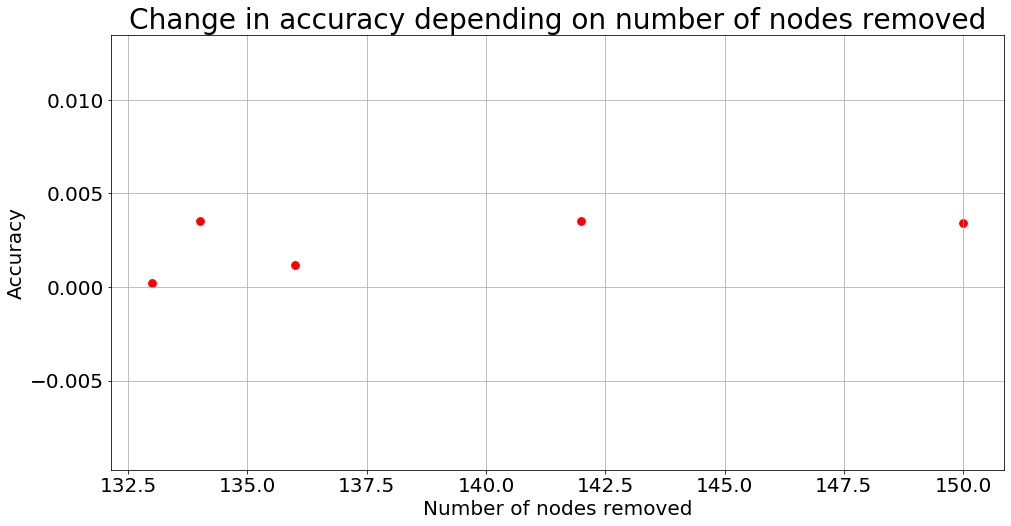

In [140]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_exh_pru_val_mnist.png")

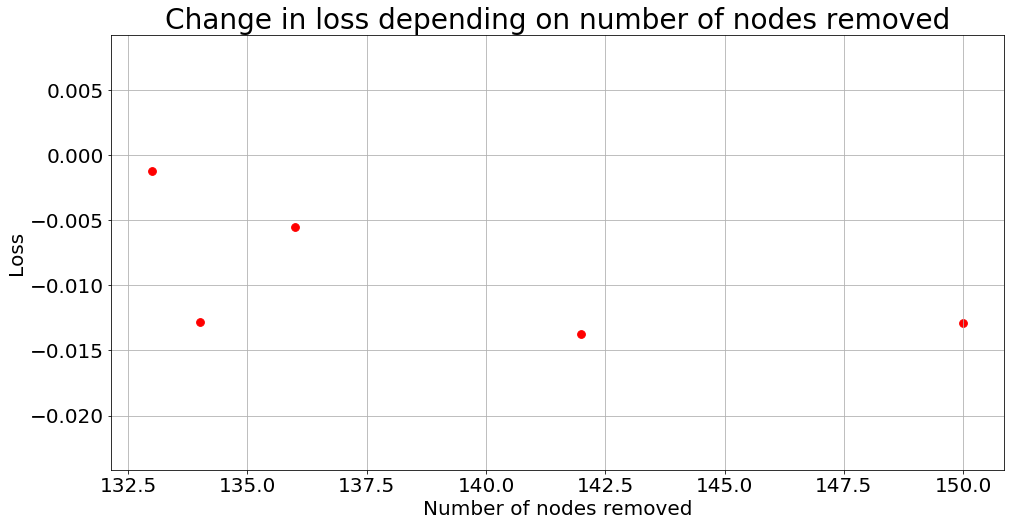

In [141]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_exh_pru_val_mnist.png")

In [142]:
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [143]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.02880847454071045, New loss: 0.026243463158607483
Original accuracy: 0.9907000064849854, New accuracy: 0.9921000003814697
Number of nodes removed: [40, 86, 20, 6, 2]


In [144]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

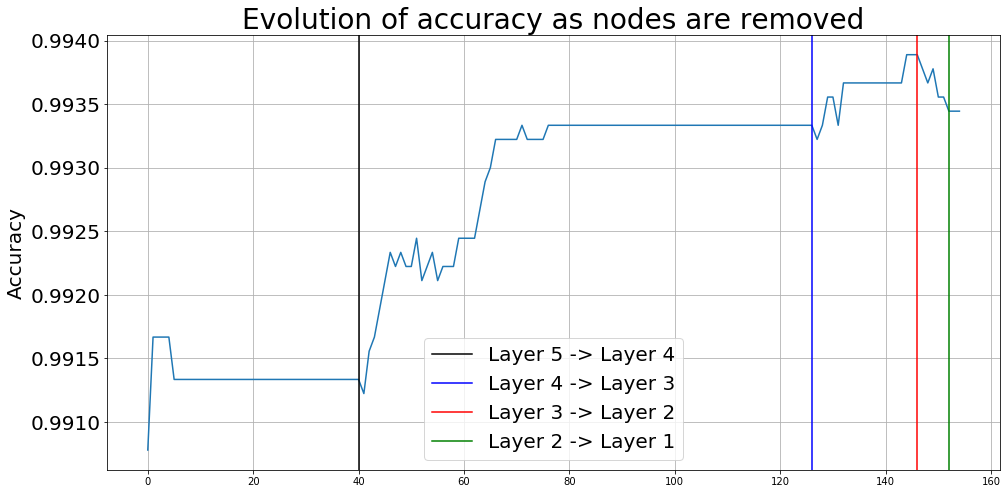

In [145]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_exh_pru_val_mnist.png")

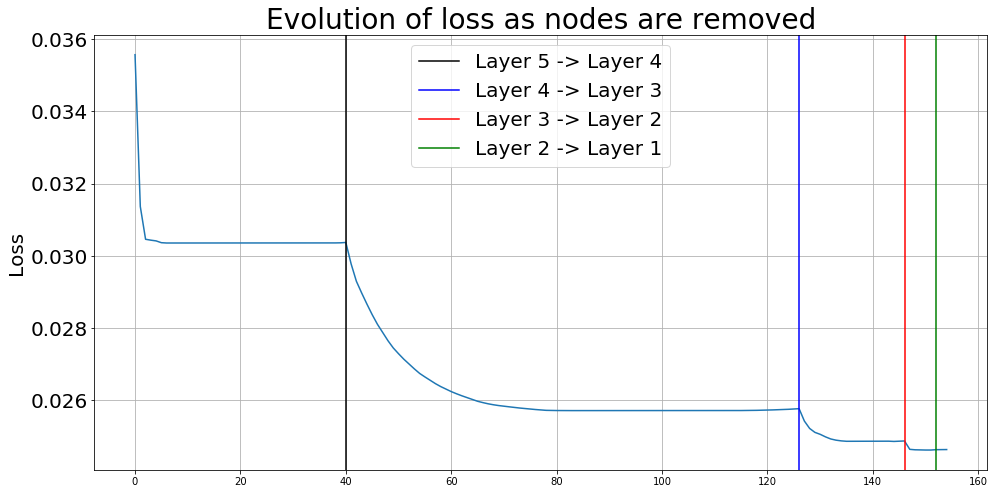

In [146]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_exh_pru_val_mnist.png")

### Fashion MNIST

#### Set seed

In [ ]:
np.random.seed(2020)

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [ ]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

In [ ]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_exh_pru_fmnist.csv')
NR.describe()

In [ ]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_exh_pru_fmnist.csv')
A.describe()

In [ ]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_exh_pru_fmnist.csv')
L.describe()

In [ ]:
num_rem = [sum(rem) for rem in num_rem]

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_exh_pru_fmnist.png")

In [ ]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_exh_pru_fmnist.png")

In [ ]:
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

In [ ]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

In [ ]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_exh_pru_fmnist.png")

In [ ]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_exh_pru_fmnist.png")

### Validation removal

In [147]:
np.random.seed(2020)

In [148]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [149]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [150]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [151]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:11:32<00:00, 2298.48s/it]


In [152]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_exh_pru_val_fmnist.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.000000,5.00000,5.000000,5.000000,5.00000
mean,32.600000,64.00000,23.000000,3.000000,2.60000
std,8.988882,7.17635,4.123106,1.870829,1.67332
min,22.000000,55.00000,20.000000,0.000000,1.00000
25%,24.000000,60.00000,20.000000,3.000000,1.00000
50%,37.000000,64.00000,20.000000,3.000000,3.00000
75%,38.000000,67.00000,27.000000,4.000000,3.00000
max,42.000000,74.00000,28.000000,5.000000,5.00000


In [153]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_exh_pru_val_fmnist.csv')
A.describe()

count    5.000000
mean     0.004940
std      0.001813
min      0.003000
25%      0.004100
50%      0.004400
75%      0.005400
max      0.007800
dtype: float64

In [154]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_exh_pru_val_fmnist.csv')
L.describe()

count    5.000000
mean    -0.019197
std      0.002666
min     -0.022546
25%     -0.021284
50%     -0.018759
75%     -0.016992
max     -0.016402
dtype: float64

In [155]:
num_rem = [sum(rem) for rem in num_rem]

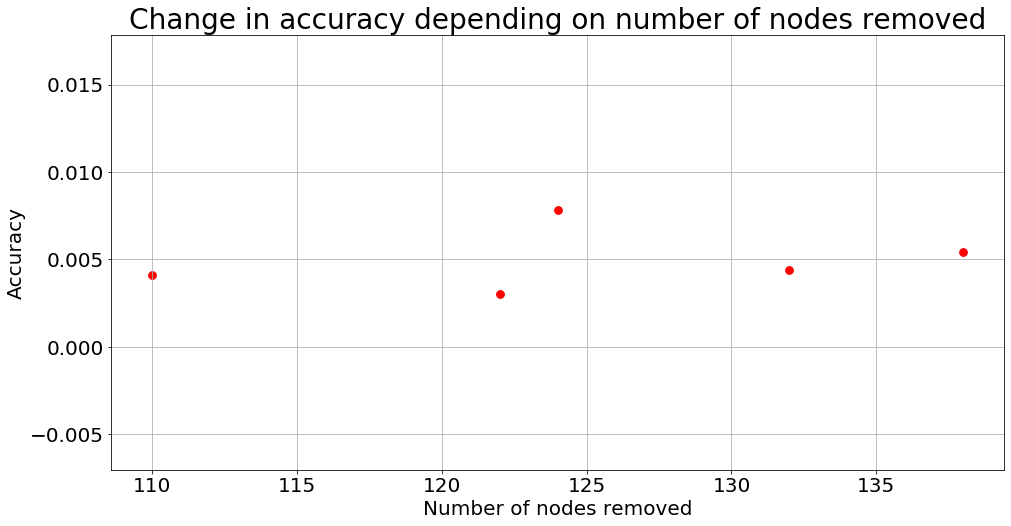

In [156]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_exh_pru_val_fmnist.png")

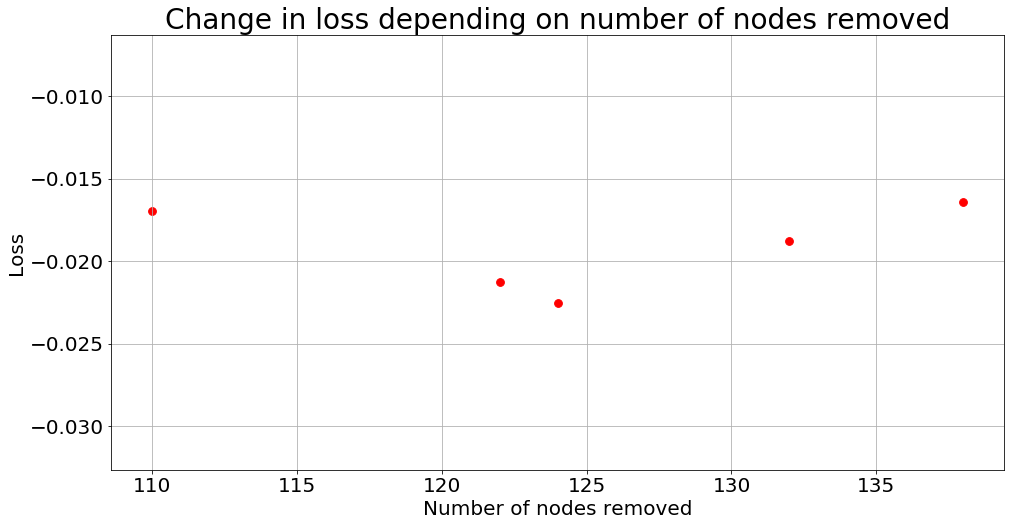

In [157]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_exh_pru_val_fmnist.png")

In [158]:
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [159]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.25024041533470154, New loss: 0.23001347482204437
Original accuracy: 0.9106000065803528, New accuracy: 0.9151999950408936
Number of nodes removed: [36, 57, 21, 0, 3]


In [160]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

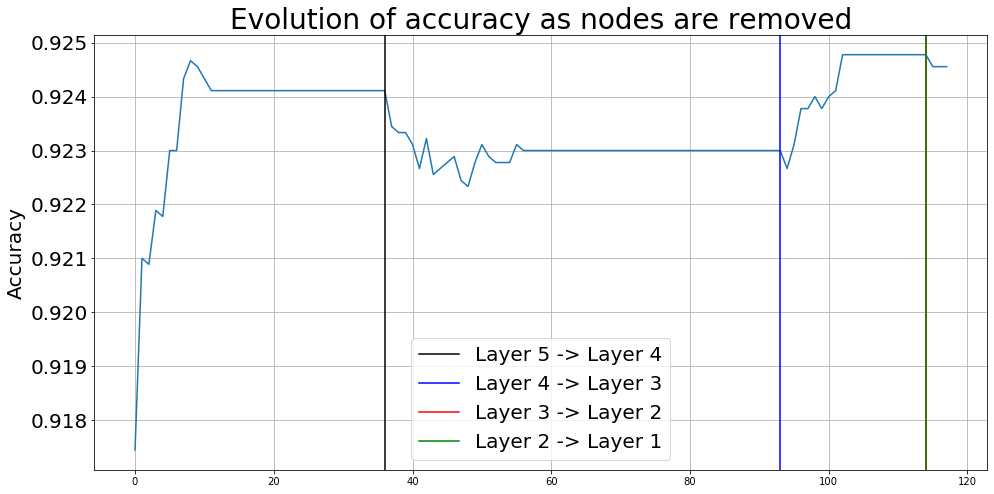

In [161]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_exh_pru_val_fmnist.png")

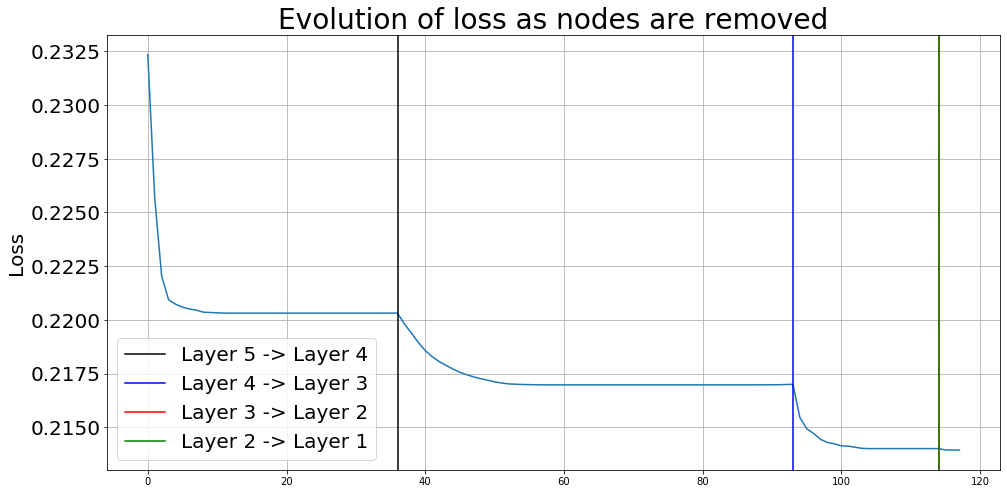

In [162]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_exh_pru_val_fmnist.png")

### CIFAR10

#### Set seed

In [ ]:
np.random.seed(2020)

In [ ]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [ ]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

In [ ]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_exh_pru_cifar.csv')
NR.describe()

In [ ]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_exh_pru_cifar.csv')
A.describe()

In [ ]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_exh_pru_cifar.csv')
L.describe()

In [ ]:
num_rem = [sum(rem) for rem in num_rem]

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_exh_pru_cifar.png")

In [ ]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_exh_pru_cifar.png")

In [ ]:
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_train, y_train, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

In [ ]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

In [ ]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_exh_pru_cifar.png")

In [ ]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_exh_pru_cifar.png")

### Validation removal

In [4]:
np.random.seed(2020)

In [5]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [6]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [8]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
    num_rem += [tmp_a]
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [7:24:43<00:00, 5336.68s/it]


In [9]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_exh_pru_val_cifar.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,44.000000,110.000000,33.200000,10.800000,3.400000
std,3.464102,3.162278,5.974948,3.962323,2.302173
min,42.000000,106.000000,28.000000,7.000000,0.000000
25%,42.000000,108.000000,29.000000,8.000000,3.000000
50%,42.000000,110.000000,32.000000,9.000000,3.000000
75%,44.000000,112.000000,34.000000,14.000000,5.000000
max,50.000000,114.000000,43.000000,16.000000,6.000000


In [10]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_exh_pru_val_cifar.csv')
A.describe()

count    5.000000
mean     0.006560
std      0.004597
min      0.002300
25%      0.002300
50%      0.007300
75%      0.007500
max      0.013400
dtype: float64

In [11]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_exh_pru_val_cifar.csv')
L.describe()

count    5.000000
mean    -0.042933
std      0.011718
min     -0.059514
25%     -0.049982
50%     -0.037688
75%     -0.037487
max     -0.029992
dtype: float64

In [12]:
num_rem = [sum(rem) for rem in num_rem]

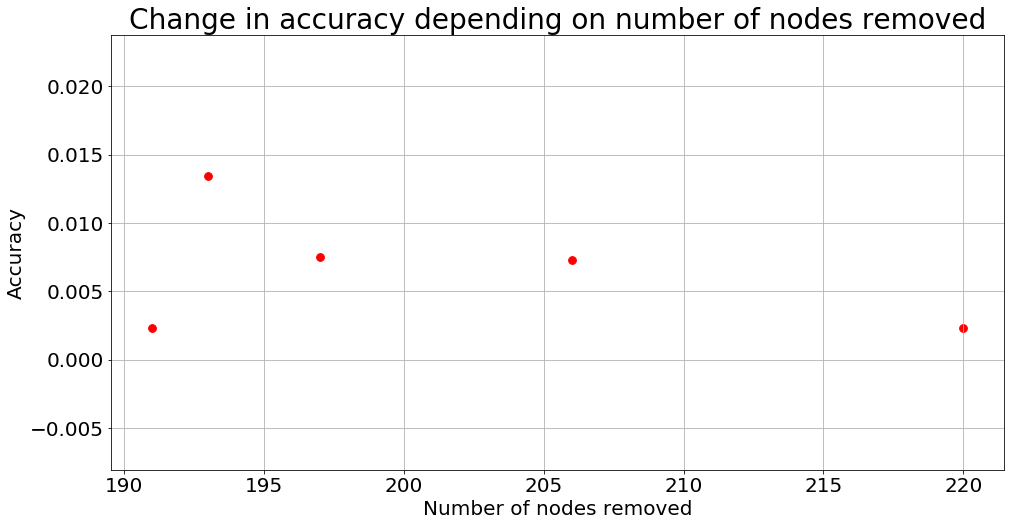

In [13]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_exh_pru_val_cifar.png")

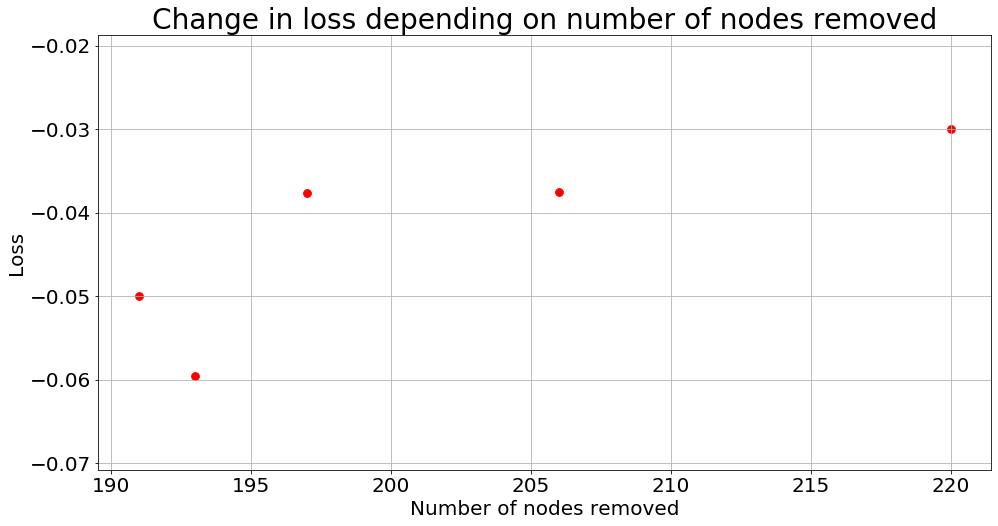

In [14]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_exh_pru_val_cifar.png")

In [15]:
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol)
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [16]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.8185723423957825, New loss: 0.7858685255050659
Original accuracy: 0.7250000238418579, New accuracy: 0.7321000099182129
Number of nodes removed: [46, 107, 43, 12, 4]


In [17]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

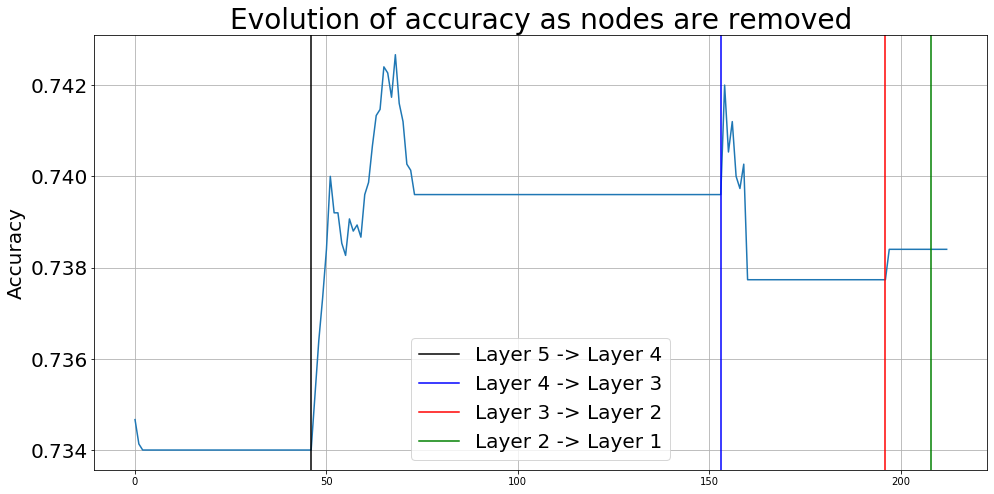

In [18]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_exh_pru_val_cifar.png")

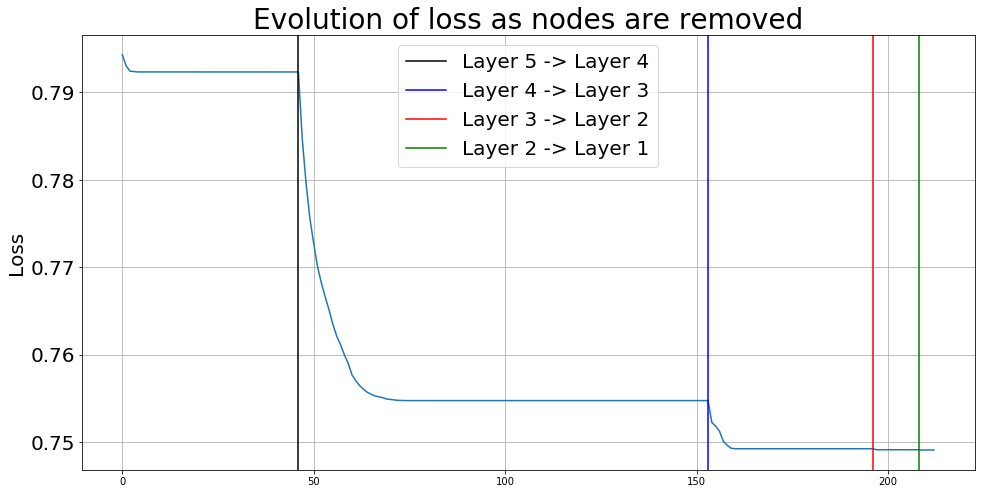

In [19]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_exh_pru_val_cifar.png")